# Домашняя работа #5 по курсу NGS
Выполнил: Ким Адамейко, группа АДБМ16, НИУ ВШЭ

## Задание 1
Визуализируйте выравнивание чтений из эксперимента (experiment.bed) и найдите пример сдвинутых кучек ридов по прямой и обратной цепи (хорошо выраженный пик).

* Рабочий тул для визуализации bed-файлов: http://genomeview.org/
* Для скорости можно отфильтровать bed-файл по одной хросомоме (grep -w)
* Обратите внимание на упрощенный формат файла с выравниванием (bed)
* Для наглядной визуализации - разрежьте файл с картированием на два, отдельно по + и по - нитям (см. для примера слайд 34)
* Риды положены на геном человека, релиз hg18 - build36
* Если вам не удается найти удачный пример пика вручную - воспользуйтесь результатами следующего задания и посмотрите где находятся пики, найденные MACS


### Решение
Скопируем файл с сервера и посмотрим на его содержимое:

In [66]:
ssh = 'ssh -p 9022 student@mg.uncb.iitp.ru'
scp = 'scp -P 9022 student@mg.uncb.iitp.ru:'

In [4]:
!{scp}~/chipseq/experiment.bed .

experiment.bed                                100%  112MB 300.9KB/s   06:20    


In [35]:
def headtail(file, n=5):
    ! head -n {n} {file}
    print('...')
    ! tail -n {n} {file}

In [36]:
headtail('./experiment.bed')

chr1	7324	7359	0	2	+
chr1	522319	522354	0	3	-
chr1	553256	553291	0	3	-
chr1	699985	700020	0	3	+
chr1	745587	745622	0	0	+
...
chrY	57429336	57429371	0	0	-
chrY	57429336	57429371	0	1	-
chrY	57429355	57429390	0	2	+
chrY	57429690	57429725	0	0	-
chrY	57435410	57435445	0	0	-


[Спецификация формата bed](https://genome.ucsc.edu/FAQ/FAQformat.html#format1) говорит, что первые три поля -- обязательные: название хромосомы, начало и конец рида; следующие поля опциональные и соответствуют отображаемому имени, очкам (в диапазоне [0, 1000]), цепи. Насколько я понял, в данном случае число очков -- это просто число ридов. Итак, какая же хромосома досталась мне?

In [15]:
chr = 'chr{}'.format(sum(list(map(lambda c: ord(c) - ord('A'), list('ADAMEYKO')))) % 22 + 1)
print(chr)

chr2


Отфильтруем строки, относящиеся только к этой хромосоме. Параметр `-w` позволяет искать только слово целиком.

In [37]:
! grep -w {chr} './experiment.bed' > './exp_chr.bed'
headtail('./exp_chr.bed')

chr2	836	871	0	1	-
chr2	1339	1374	0	3	+
chr2	4491	4526	0	1	+
chr2	4783	4818	0	4	+
chr2	4783	4818	0	0	+
...
chr2	242689965	242690000	0	2	-
chr2	242689965	242690000	0	0	-
chr2	242691061	242691096	0	3	+
chr2	242694803	242694838	0	2	-
chr2	242713832	242713867	0	0	+


Теперь это подмножество строк разобьем ещё на два, в соответствии с цепью (+/-). 
Параметр `-e` защищает регулярные выражения, начинающиеся с дефиса, иначе они будут поняты как параметры.

In [40]:
! grep -e '-$' './exp_chr.bed' > './exp_chr_minus.bed'
! grep '\+$' './exp_chr.bed' > './exp_chr_plus.bed'
print('MINUS STRAND')
headtail('./exp_chr_minus.bed')
print('\nPLUS STRAND')
headtail('./exp_chr_plus.bed')

MINUS STRAND
chr2	836	871	0	1	-
chr2	4787	4822	0	0	-
chr2	5674	5709	0	1	-
chr2	7343	7378	0	0	-
chr2	7343	7378	0	1	-
...
chr2	242689122	242689157	0	3	-
chr2	242689587	242689622	0	1	-
chr2	242689965	242690000	0	2	-
chr2	242689965	242690000	0	0	-
chr2	242694803	242694838	0	2	-

PLUS STRAND
chr2	1339	1374	0	3	+
chr2	4491	4526	0	1	+
chr2	4783	4818	0	4	+
chr2	4783	4818	0	0	+
chr2	7270	7305	0	0	+
...
chr2	242666704	242666739	0	2	+
chr2	242683155	242683190	0	1	+
chr2	242688987	242689022	0	5	+
chr2	242691061	242691096	0	3	+
chr2	242713832	242713867	0	0	+


Несколько "пиков", найденных глазами в GenomeView

![](genome_view4.png)
![](genome_view5.png)
![](genome_view6.png)

## Задание 2
* Запустите MACS1 на тестовых данных:
  
  `macs -c control.bed -t experiment.bed -g hs -n [шаблон_имен_файлов_результатов]`
  
  Формы пиков можно достать путем `-w` или `-B` - получится bedGraph или wiggle (осторожно, огромные файлы). 
  `-g hs` устанавливает эффективный размер генома (hs = homo sapiens).
  > Обратите внимание на файл .r в результатах - это "модель" кластеризации ридов, построенная MACS (можно сконвертировать в pdf с помощью R и посмотреть)

* Запустите MACS2 на тестовых данных:

  `macs2 callpeak -t experiment.bed -c control.bed -g hs -n [аналогично_но_не_затрите_файлы]`
  

* Грубо сравните результаты MACS1 и MACS2 путем пересечения интервалов (сколько пиков хоть как-то пересекается?):
  
  `bedtools intersect -a [тут_пики_macs14] -b [тут_пики_macs2]`


### Решение
Для начала создам отдельную папку на сервере и проверю, что данные на месте

In [60]:
!{ssh} mkdir -p './adameyko' 
!{ssh} ls './chipseq'         

arch.zip
chipmunk.jar
control.bed
experiment.bed
hg18
macs1
sarus.jar


In [62]:
!{ssh} '~/chipseq/macs1/usr/bin/macs14' -c '~/chipseq/control.bed' -t '~/chipseq/experiment.bed' -g hs -n './adameyko/task2_macs14'

INFO  @ Sat, 16 Dec 2017 04:20:00: 
# ARGUMENTS LIST:
# name = ./adameyko/task2_macs14
# format = AUTO
# ChIP-seq file = /home/student/chipseq/experiment.bed
# control file = /home/student/chipseq/control.bed
# effective genome size = 2.70e+09
# band width = 300
# model fold = 10,30
# pvalue cutoff = 1.00e-05
# Large dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
 
INFO  @ Sat, 16 Dec 2017 04:20:00: #1 read tag files... 
INFO  @ Sat, 16 Dec 2017 04:20:00: #1 read treatment tags... 
INFO  @ Sat, 16 Dec 2017 04:20:00: Detected format is: BED 
INFO  @ Sat, 16 Dec 2017 04:20:05:  1000000 
INFO  @ Sat, 16 Dec 2017 04:20:11:  2000000 
INFO  @ Sat, 16 Dec 2017 04:20:17:  3000000 
INFO  @ Sat, 16 Dec 2017 04:20:22: #1.2 read input tags... 
INFO  @ Sat, 16 Dec 2017 04:20:22: Detected format is: BED 
INFO  @ Sat, 16 Dec 2017 04:20:28:  1000000 
INFO  @ Sat, 16 Dec 2017 04:20:34:  2000000 
INFO  @ Sat, 16 Dec 2017 04:20:40:  3000

In [63]:
!{ssh} head ./adameyko/task2_macs14_peaks.bed 

chr1	858356	858641	MACS_peak_1	51.00
chr1	998954	999229	MACS_peak_2	74.39
chr1	1050020	1050286	MACS_peak_3	152.00
chr1	1684287	1684577	MACS_peak_4	89.70
chr1	1775030	1775371	MACS_peak_5	51.08
chr1	1780681	1780965	MACS_peak_6	61.17
chr1	1923146	1923449	MACS_peak_7	164.87
chr1	2110969	2111170	MACS_peak_8	67.53
chr1	2111407	2111732	MACS_peak_9	71.96
chr1	2232813	2233120	MACS_peak_10	63.91


In [67]:
!{ssh} r ./adameyko/task2_macs14_model.r 
!{scp}~/adameyko/task2_macs14_model.pdf .

task2_macs14_model.pdf                        100%   21KB  21.4KB/s   00:00    


In [75]:
from IPython.display import IFrame
IFrame('./task2_macs14_model.pdf', width=400, height=430)

In [65]:
!{ssh} macs2 -c '~/chipseq/control.bed' -t '~/chipseq/experiment.bed' -g hs -n './adameyko/task2_macs2'

INFO  @ Sat, 16 Dec 2017 04:46:45: 
# ARGUMENTS LIST:
# name = ./adameyko/task2_macs2
# format = AUTO
# ChIP-seq file = /home/student/chipseq/experiment.bed
# control file = /home/student/chipseq/control.bed
# effective genome size = 2.70e+09
# band width = 300
# model fold = 10,30
# qvalue cutoff = 1.00e-02
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
 
INFO  @ Sat, 16 Dec 2017 04:46:45: #1 read tag files... 
INFO  @ Sat, 16 Dec 2017 04:46:45: #1 read treatment tags... 
INFO  @ Sat, 16 Dec 2017 04:46:45: Detected format is: BED 
INFO  @ Sat, 16 Dec 2017 04:46:49:  1000000 
INFO  @ Sat, 16 Dec 2017 04:46:53:  2000000 
INFO  @ Sat, 16 Dec 2017 04:46:56:  3000000 
INFO  @ Sat, 16 Dec 2017 04:47:00: #1.2 read input tags... 
INFO  @ Sat, 16 Dec 2017 04:47:00: Detected format is: BED 
INFO  @ Sat, 16 Dec 2017 04:47:03:  1000000 
INFO  @ Sat, 16 Dec 2017 04:47:07:  2000000 
INFO  @ Sa

In [76]:
!{ssh} r ./adameyko/task2_macs2_model.r 
!{scp}~/adameyko/task2_macs2_model.pdf .

task2_macs2_model.pdf                         100%   21KB  21.4KB/s   00:00    


In [77]:
from IPython.display import IFrame
IFrame('./task2_macs2_model.pdf', width=400, height=430)

In [199]:
!{ssh} head ./adameyko/task2_macs2_peaks.bed 
!{ssh} wc -l ./adameyko/task2_macs2_peaks.bed 

chr1	999016	999135	MACS_peak_1	4.64
chr1	1050067	1050243	MACS_peak_2	14.29
chr1	1684389	1684525	MACS_peak_3	7.61
chr1	1923247	1923420	MACS_peak_4	18.92
chr1	3266141	3266348	MACS_peak_5	26.69
chr1	3493790	3494030	MACS_peak_6	10.24
chr1	3531128	3531270	MACS_peak_7	10.50
chr1	4609552	4609703	MACS_peak_8	13.49
chr1	5580802	5580936	MACS_peak_9	5.46
chr1	6395626	6395824	MACS_peak_10	16.33
7815 ./adameyko/task2_macs2_peaks.bed


Видим, что пиков с помощью новой версии алгоритма получилось почти вдвое меньше. Посмотрим, сколько пиков из старых результатов перешли в новые. Согласно [документации функции `intersect`](http://bedtools.readthedocs.io/en/latest/content/tools/intersect.html), я использовал опцию `-u` для фильтрации  интервалов, которые пересекаются хотя бы в одной базе, но при этом если один интервал в А включает в себя два интервала в В, то этот интервал всё равно будет выведен только один раз, что мне и нужно.

In [96]:
m14bed = './adameyko/task2_macs14_peaks.bed'
m2bed  = './adameyko/task2_macs2_peaks.bed'
mcbed  = './adameyko/task2_common_peaks.bed'
!{ssh} "bedtools intersect -a {m14bed} -b {m2bed} -u > {mcbed}"
!{ssh} head {mcbed}
!{ssh} wc -l {mcbed}

chr1	998954	999229	MACS_peak_2	74.39
chr1	1050020	1050286	MACS_peak_3	152.00
chr1	1684287	1684577	MACS_peak_4	89.70
chr1	1923146	1923449	MACS_peak_7	164.87
chr1	3265973	3266359	MACS_peak_12	238.33
chr1	3493693	3494178	MACS_peak_15	168.05
chr1	3531104	3531295	MACS_peak_16	138.36
chr1	4609534	4609770	MACS_peak_21	138.36
chr1	5580633	5580999	MACS_peak_22	115.29
chr1	6395536	6395952	MACS_peak_25	207.03
7691 ./adameyko/task2_common_peaks.bed


In [97]:
7691 / 13591

0.5658891913766463

Итак, как можно видеть, всего лишь чуть больше половины пиков, найденных старой версией алгоритма, совпали каким-либо образом с пиками, найденными новой версией алгоритма. Разница видна и во времени выполнения: новый алгоритм работает в несколько раз медленнее: 13 минут против 1.5! А вот графики распределений не сильно отличаются.

## Задание 3
1. Выбор пиков для для конкретной хромосомы:
    `grep chr22 -w test_peaks.bed > peaks_chr22.bed`
2. Экстракция последовательностей
    `bedtools getfasta -fi [тут_относительный_путь_к_геному]/hg18/chr22.fa -bed peaks_chr22.bed -fo peaks_chr22.mfa`
3. Поиск мотива
    `java -jar [тут_относительный_путь_к_jar_файлу]/chipmunk.jar s:peaks_chr22.mfa > motif.log`
   (из вывода нужно будет скопировать весовую матрицу - в самом конце файла вывода motif.log)
    Если вам удастся скачать fasta-файл с последовательностями с сервера к себе - можно использовать веб-версию ChIPMunk: http://opera.autosome.ru/chipmunk/discovery/mono/new. Она картиночки рисует и дает скачать матрицу в удобном виде.

4. *Выяснение какому белку мог бы принадлежать мотив (нужно будет достать матрицу из log-файла): MACRO-APE.
<на сайте для желающих есть и консольная версия с инструкцией>

5. **Определение позиционных предпочтений мотива в пиках (нужен будет дополнительный анализ файла результата + последовательностей):
`java -jar ../sarus.jar peaks_chr22.mfa motif.log besthit > sarus.log`


### Решение
Я буду использовать пики, выданные более аккуратным алгоритмом macs2. Отфильтрую хромосому согласно варианту и извлеку последовательности, соответствующие пикам, в виде файлов fasta. Проверю, что в файлах всё хорошо.

In [122]:
task3 = './adameyko/task3_peaks_chr'
!{ssh} "grep {chr} -w {m2bed} > {task3}.bed"
!{ssh} head -n 3 {task3}.bed
!{ssh} bedtools getfasta -fi './chipseq/hg18/{chr}.fa' -bed {task3}.bed -fo {task3}.mfa
!{ssh} head -n 6 {task3}.mfa

chr2	100078	100252	MACS_peak_3286	26.12
chr2	105395	105547	MACS_peak_3287	8.43
chr2	250795	251086	MACS_peak_3288	66.99
>chr2:100078-100252
TTTTCAACGTAAAGGTTACTTATGAGCTGACAAAAACCAATGCTAGCTGTGCCAAGATCTAACACAAACAGAAATTCCTACAATCAGAGGAAAGGGTAGAGGCTGTGTTTGTTTAAAAAGCTGATTATACACACATGTAATTGGTGTGTACTTTAAAGTAATGAGTTACATATT
>chr2:105395-105547
CCATAGCCTTGGTTCCCCTTGTCTGCTGCTTATGAAGCAAGATAAACATGCTGCCTCCTCCTGGTGCAGCTCTTGAAATGTTTTGACTTCCTGTCACTGGAGAGGTGTTGACATGCTCAGGGGAATGTTGGTGGAACTCACTCTGCATTCCA
>chr2:250795-251086
TTGAACTCTCTCAACCAAGCAGTATTAGAGCAAATAAGCAAATTCCTCAGTTGAGAGTTAATCTTGCAAACATCCTGCTGTAGGGAAAGGTCATGGCCTGATCTGTAAACACGGGAAGAGAGCCATTGGACTTGGGAATCAGATGCAGCCTCACACGGCTGCAGACCGCAAGACTCATCCTAGACACAGCTTATGTCACTGTGATCCAGCTGTTGACAAGGCTGGTCACAGTGAGGACATCTTCAGTGTGTCAGCTGAACTACAGAAAATGTTACAGATTCTAATCAACTT


Запустим анализ...

In [129]:
!{ssh} "java -jar './chipseq/chipmunk.jar' s:{task3}.mfa 1>{task3}_res.txt 2>{task3}.log"

Проверим лог. Вроде всё хорошо, "success", хотя прогресс почему-то остановился на 30%, ну да ладно. 

In [132]:
!{ssh} tail {task3}.log

overall progress: 28% complete (motif discovery, length 11: 70.0% complete)
overall progress: 29% complete (motif discovery, length 11: 80.0% complete)
overall progress: 30% complete (motif discovery, length 11: 90.0% complete)
success; best KDIC 0.5467287494225969
checking motif strength...
applying ZOOPS segmentation procedure...
ZOOPS detected motif in 659 sequences of 703
motif strength check not passed, taking previously found motif
success; final motif length: 10
estimating P-value...


#### Построение лого
Так как `Biopython` не умеет строить лого по PSSM, я извёлк результат в виде счетов (PFM): 

In [195]:
pwm_txt = !! {ssh} tail -n 19 {task3}_res.txt | head -n 4
pwm_txt

['A|291.0 338.0 344.0 108.0 5.0 563.0 621.9999999999999 643.9999999999999 0.0 643.9999999999999',
 'C|22.0 83.0 4.0 0.0 209.0 83.0 23.0 0.0 504.99999999999994 1.0',
 'G|12.0 183.00000000000003 62.0 534.9999999999999 0.0 0.0 0.0 2.0 1.0 0.0',
 'T|321.0 42.0 236.00000000000003 3.0 431.99999999999994 0.0 1.0 0.0 140.0 1.0']

In [196]:
pwm = [list(map(lambda x: round(float(x)), line[2:].split())) for line in pwm_txt]
pwm

[[291, 338, 344, 108, 5, 563, 622, 644, 0, 644],
 [22, 83, 4, 0, 209, 83, 23, 0, 505, 1],
 [12, 183, 62, 535, 0, 0, 0, 2, 1, 0],
 [321, 42, 236, 3, 432, 0, 1, 0, 140, 1]]

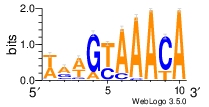

In [198]:
with open('./motif.pfm', 'w') as f:
    for line in pwm:
        print(*line, file=f)
        
from Bio import motifs
with open('./motif.pfm') as f:
    m = motifs.read(f, "pfm")

m.weblogo('./logo.png')
from IPython.display import Image
Image('./logo.png')

#### Поиск белка по мотиву
Скачаем и распакуем базу HOCOMOCO, а также программу MACRO-APE.

In [213]:
task4 = './adameyko/task4'
!{ssh} wget -nv -P {task4}/ http://hocomoco11.autosome.ru/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_pwm_HUMAN_mono.tar.gz

--2017-12-17 18:10:44--  http://hocomoco11.autosome.ru/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_pwm_HUMAN_mono.tar.gz
Resolving hocomoco11.autosome.ru (hocomoco11.autosome.ru)... 85.89.112.154
Connecting to hocomoco11.autosome.ru (hocomoco11.autosome.ru)|85.89.112.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160565 (157K) [application/octet-stream]
Saving to: ‘./adameyko/task4/HOCOMOCOv11_core_pwm_HUMAN_mono.tar.gz’

     0K .......... .......... .......... .......... .......... 31%  114K 1s
    50K .......... .......... .......... .......... .......... 63% 1,77M 0s
   100K .......... .......... .......... .......... .......... 95% 1,04M 0s
   150K ......                                                100%  270K=0,5s

2017-12-17 18:10:45 (291 KB/s) - ‘./adameyko/task4/HOCOMOCOv11_core_pwm_HUMAN_mono.tar.gz’ saved [160565/160565]



In [225]:
!{ssh} mkdir -p {task4}/hocomoco
!{ssh} tar -zxf {task4}/HOCOMOCOv11_core_pwm_HUMAN_mono.tar.gz -C {task4}/hocomoco/
!{ssh} ls {task4}/hocomoco/pwm | head -n 5

AHR_HUMAN.H11MO.0.B.pwm
AIRE_HUMAN.H11MO.0.C.pwm
ALX1_HUMAN.H11MO.0.B.pwm
ANDR_HUMAN.H11MO.0.A.pwm
AP2A_HUMAN.H11MO.0.A.pwm


In [227]:
!{ssh} wget -nv -P {task4}/ http://opera.autosome.ru/downloads/ape.jar

2017-12-17 18:17:08 URL:http://opera.autosome.ru/downloads/ape.jar [5043272/5043272] -> "./adameyko/task4/ape.jar" [1]


Извлечем теперь не PFM, а PSSM и скопируем её на сервер: 

In [232]:
pwm_txt = !! {ssh} tail -n 14 {task3}_res.txt | head -n 4
import numpy as np
pwm = np.array([list(map(lambda x: float(x), line[5:].split())) for line in pwm_txt])
with open('./motif_task4.pssm', 'w') as f:
    print('>MOTIF', file=f)
    for line in pwm.T:
        print(*line, file=f)
!cat './motif_task4.pssm'

>MOTIF
0.584394953115 -1.93247559969 -2.48310161732 0.681996005152
0.733348547498 -0.656328562236 0.123815174433 -1.31900899692
0.75086122518 -3.36854971997 -0.941580293793 0.376191053784
-0.397473168664 -4.61346671469 1.19081389732 -3.56457530659
-3.20472416655 0.255572615806 -4.61346671469 0.977691244682
1.24167683938 -0.656328562236 -4.61346671469 -4.61346671469
1.3410654948 -1.89100633399 -4.61346671469 -4.13217600312
1.37573550739 -4.61346671469 -3.80863359485 -4.61346671469
-4.61346671469 1.13328465016 -4.13217600312 -0.141340852785
1.37573550739 -4.13217600312 -4.61346671469 -4.13217600312


In [234]:
!scp -P 9022 './motif_task4.pssm' 'student@mg.uncb.iitp.ru:{task4}/motif.pssm'

motif_task4.pssm                              100%  604     0.6KB/s   00:00    


**Наконец, запустим программу согласно разделу 5.1.1 [инструкции](http://opera.autosome.ru/downloads/MACRO-PERFECTOS-APE_manual.pdf):**

In [235]:
!{ssh} java -cp {task4}/ape.jar ru.autosome.macroape.ScanCollection {task4}/motif.pssm {task4}/hocomoco/pwm

# MS: minimal similarity to output
# P: P-value
# PB: P-value boundary
# V: discretization value
# MS = 0.05
# P = 5.0E-4
# PB = upper
# V = 1.0
#
# motif	similarity	shift	overlap	orientation
FOXQ1_HUMAN.H11MO.0.C	0.07434531043867576	1	9	revcomp
FOXO4_HUMAN.H11MO.0.C	0.09801324503311258	2	8	revcomp
ANDR_HUMAN.H11MO.0.A	0.10269101633978282	2	8	revcomp
FOXJ3_HUMAN.H11MO.0.A	0.1028699167402886	-2	10	revcomp
FOXP1_HUMAN.H11MO.0.A	0.11197456729071	3	7	revcomp
FOXO1_HUMAN.H11MO.0.A	0.14589307815377184	2	8	revcomp
FOXC1_HUMAN.H11MO.0.C	0.157272491573762	-2	10	revcomp
FOXJ2_HUMAN.H11MO.0.C	0.16842105263157894	0	10	revcomp
FOXK1_HUMAN.H11MO.0.A	0.20421052631578948	0	10	revcomp
FOXO3_HUMAN.H11MO.0.B	0.23605970149253733	2	8	revcomp
FOXP2_HUMAN.H11MO.0.C	0.2560232989144824	2	8	revcomp
FOXM1_HUMAN.H11MO.0.A	0.34997426659804426	-2	10	revcomp
FOXA3_HUMAN.H11MO.0.B	0.3989217534763139	-1	10	revcomp
FOXA1_HUMAN.H11MO.0.A	0.5120998045994288	-2	10	revcomp
FOXA2_HUMAN.H11MO.0.A	0.5172776442307693	-2	10	rev

По результатам анализа можно сказать, что данный белок скорее всего относится к семейству транскрипционных факторов FOX; в частности, наиболее высокой схожестью с матрицей выделенного мтоива обладают факторы FOXA1/2/3, так называемые *ядерные факторы гепатоцитов*, играющие важную роль в развитии печени и почек.